# Recovering from errors during optimization

In [1]:
import numpy as np
import tensorflow as tf
import random

np.random.seed(1793)
tf.random.set_seed(1793)
random.seed(3)

Sometimes the Bayesian optimization process encounters an error from which we can recover, without the need to restart the run from the beginning. In this tutorial, we'll simulate such an error and show how to recover from it.

We'll use a similar setup to the [EI notebook](expected_improvement.ipynb), but use an observer that intermittently breaks when evaluated, and needs manual attention to get running again. We can simulate fixing the observer with its `manual_fix` method.

In [2]:
import trieste
from trieste.utils.objectives import branin


class FaultyBranin:
    def __init__(self):
        self._is_broken = False

    def manual_fix(self):
        self._is_broken = False

    def __call__(self, x):
        if random.random() < 0.05:
            self._is_broken = True

        if self._is_broken:
            raise Exception("Observer is broken")

        return trieste.data.Dataset(x, branin(x))


observer = FaultyBranin()

## Set up the problem
We'll use the same set up as before, except for the acquisition rule, where we'll use `TrustRegion`, which (with non-trivial state) will better illustrate how to recover.

In [3]:
import gpflow

search_space = trieste.space.Box(
    tf.cast([0.0, 0.0], tf.float64), tf.cast([1.0, 1.0], tf.float64)
)
initial_data = observer(search_space.sample(5))

variance = tf.math.reduce_variance(initial_data.observations)
kernel = gpflow.kernels.Matern52(variance, [0.2, 0.2]) + gpflow.kernels.White(1e-12)
gpr = gpflow.models.GPR(
    initial_data.astuple(), kernel, noise_variance=1e-5
)
gpflow.set_trainable(gpr.likelihood, False)
model = trieste.models.GaussianProcessRegression(gpr)

acquisition_rule = trieste.acquisition.rule.TrustRegion()

## Run the optimization loop

In this tutorial we'll try to complete fifteen optimization loops, which, with the broken observer, may take more than one attempt. The optimizer returns an `OptimizationResult`, which is simply a container for both:

  * the final result, which uses a `Result` type (not to be confused with `OptimizationResult`) to safely encapsulate the final data, models and acquisition state if the process completed successfully, or an error if one occurred
  * the history of the successful optimization steps.

We can access these with the `astuple` method.

In [4]:
bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)

result, history = bo.optimize(15, initial_data, model, acquisition_rule).astuple()


Optimization failed at step 5, encountered error with traceback:
Traceback (most recent call last):
  File "/opt/hostedtoolcache/Python/3.7.10/x64/lib/python3.7/site-packages/trieste/bayesian_optimizer.py", line 325, in optimize
    observer_output = self._observer(query_points)
  File "<ipython-input-1-bfc5894519f6>", line 17, in __call__
    raise Exception("Observer is broken")
Exception: Observer is broken

Terminating optimization and returning the optimization history. You may be able to use the history to restart the process from a previous successful optimization step.



We can see from the logs that the optimization loop failed, and this can be sufficient to know what to do next if we're working in a notebook. However, sometimes our setup means we don't have access to the logs. We'll pretend from here that's the case.

## Handling success

We don't know if the optimization completed successfully or not, so we'll only try to access and plot the data if it was successful. We can find out if this was the case with `result`'s `is_ok` attribute. If it was successful, we know there is data in the `result`, which we can `unwrap` and view.

In [5]:
if result.is_ok:
    data = result.unwrap().dataset
    print("best observation: ", tf.reduce_min(data.observations))

## Handling failure

If on the other hand, the optimization didn't complete successfully, we can fix our observer, and try again. We can try again by using the data, model and acquisition state from the last successful step, which is the last element of the `history`.

Note we can view any `Result` by printing it. We'll do that here to see what exception was caught.

In [6]:
if result.is_err:
    print("result: ", result)

    observer.manual_fix()

    result, new_history = bo.optimize(
        15 - len(history),
        history[-1].dataset,
        history[-1].model,
        acquisition_rule,
        history[-1].acquisition_state
    ).astuple()

    history.extend(new_history)

result:  Err(Exception('Observer is broken'))


Optimization completed without errors


We can repeat this until we've spent our optimization budget, using a loop if appropriate. But here, we'll just plot the data if it exists, safely by using `result`'s `is_ok` attribute.

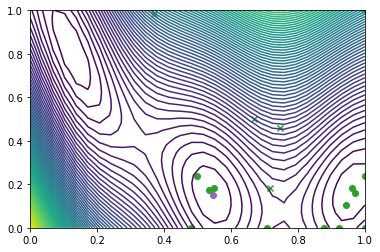

In [7]:
from util.plotting import plot_bo_points, plot_function_2d

if result.is_ok:
    data = result.unwrap().dataset
    arg_min_idx = tf.squeeze(tf.argmin(data.observations, axis=0))
    _, ax = plot_function_2d(
        branin, search_space.lower, search_space.upper, 30, contour=True
    )
    plot_bo_points(data.query_points.numpy(), ax[0, 0], 5, arg_min_idx)

## LICENSE

[Apache License 2.0](https://github.com/secondmind-labs/trieste/blob/develop/LICENSE)